In [1]:
# Importing Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.utils import image_dataset_from_directory
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing import image
from PIL import Image
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Storing the folder paths
bike_path = 'C:/Users/ADMIN/Downloads/archive (2).csv/Car-Bike-Dataset/Bike'
car_path = 'C:/Users/ADMIN/Downloads/archive (2).csv/Car-Bike-Dataset/Car'

In [3]:
bike_files_len = len(os.listdir(bike_path))
car_files_len = len(os.listdir(car_path))
print(f'Total Number of Images in Bike folder are: {bike_files_len}')
print(f'Total Number of Images in Car folder are: {car_files_len}')

Total Number of Images in Bike folder are: 2000
Total Number of Images in Car folder are: 2000


In [4]:
all_file = [f for f in os.listdir(bike_path) if os.path.isfile(os.path.join(bike_path, f))]
print(len(all_file))
random.sample(all_file, 5)

2000


['Bike (246).jpeg',
 'Bike (574).jpeg',
 'Bike (27).png',
 'Bike (1257).jpeg',
 'Bike (1574).jpeg']

In [5]:
def load_sample_images(folder_path, sample_size = 5):
    # Getting the total files so we can sample it
    all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    # Sampling the 5 files from total files
    sample_files = random.sample(all_files, sample_size)
    
    images = []
    for file in sample_files:
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path)
        images.append(img)
    
    return images

In [6]:
bike_sample_img = load_sample_images(bike_path)
car_sample_img = load_sample_images(car_path)

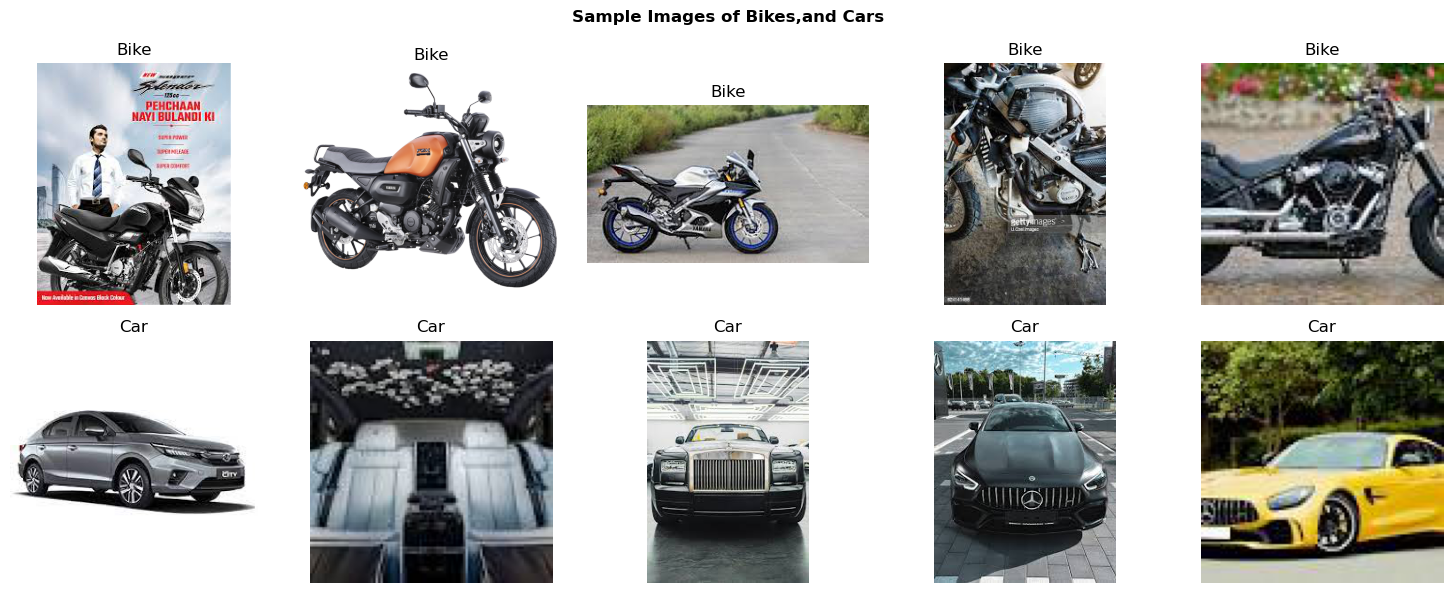

In [7]:
# Plotting the sample images from dataset
all_img_sample = [bike_sample_img, car_sample_img]
fig, axes = plt.subplots(2, len(bike_sample_img), figsize=(15,6))
title = ['Bike', 'Car']
for row, category in enumerate(all_img_sample):
  for i, img in enumerate(category):
    axes[row, i].imshow(img)
    axes[row, i].set_title(title[row])
    axes[row, i].axis('off')

plt.suptitle('Sample Images of Bikes,and Cars', fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
input_folder = 'C:/Users/ADMIN/Downloads/archive (2).csv/Car-Bike-Dataset'
output_folder = 'output'

splitfolders.ratio(input_folder, output = output_folder, seed = 1337, ratio = (0.8, 0.2), group_prefix=None)

print("Data has been splited into Train and Test successfully!")

Copying files: 4000 files [00:17, 233.79 files/s]

Data has been splited into Train and Test successfully!


In [23]:
#Showing number of Car file in train and test folder (Demo code or kind a implementation technique so if its work will convert into a function)
train_car_path = 'output/train/Car'
test_car_path = 'output/val/Car'
train_car_files_len = len(os.listdir(train_car_path))
test_car_files_len = len(os.listdir(test_car_path))
print(f'Total Number of Car Images in Train folder are: {train_car_files_len}')
print(f'Total Number of Car Images in Test  folder are: {test_car_files_len}')

Total Number of Car Images in Train folder are: 1600
Total Number of Car Images in Test  folder are: 400


In [24]:
# Now creating a function which will help to count the numbers of file in all folders which are in train and test
def count_files_in_folders(base_path):
    folder_data = []
    if not os.path.exists(base_path):
        print(f"The path {base_path} does not exist.")
        return folder_data
    
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            num_files = 0
            for item in os.listdir(folder_path):
                if os.path.isfile(os.path.join(folder_path, item)):
                    num_files += 1
            folder_data.append((folder, num_files))
    
    return folder_data

In [25]:
train_path = 'output/train'
test_path =  'output/val'

In [26]:
train_data_count = count_files_in_folders(train_path)
test_data_count = count_files_in_folders(test_path)

In [27]:
# Numbers of train test dataset for each category
train_df = pd.DataFrame(train_data_count, columns=['Folder', 'NumFiles'])
test_df = pd.DataFrame(test_data_count, columns=['Folder', 'NumFiles'])

# Adding a column
train_df['Type'] = 'Train'
test_df['Type'] = 'Test'

# Combine the data
combined_df = pd.concat([train_df, test_df])

combined_df

,Folder,NumFiles,Type
0,Bike,1600,Train
1,Car,1600,Train
0,Bike,400,Test
1,Car,400,Test


In [28]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range=15)

test_datagen =  ImageDataGenerator(rescale = 1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    directory= test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [30]:
train_generator.class_indices

{'Bike': 0, 'Car': 1}

In [31]:
# Creating Model Architecture
model = Sequential()

model.add(Conv2D(56, kernel_size = (3,3), activation = 'relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(28, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D((3,3)))

model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(32, activation = 'relu'))
model.add(Dense(14, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 56)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 56)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 28)        │          14,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 16)          │           4,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4624)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │         148,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 14)                  │             462 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,233 (657.16 KB)

 Trainable params: 168,233 (657.16 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
plot_model(model, show_shapes = True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [34]:
# Compiling the model wiht loss binary cross entropy and optimizer Adam
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [35]:
# Training the model and storing the information into history vairable
history = model.fit(
    train_generator, 
    validation_data=validation_generator,
    epochs=1
)

100/100 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.5684 - loss: 0.6658 - val_accuracy: 0.8500 - val_loss: 0.3890


In [40]:
def get_true_and_predicted_labels(generator, model, threshold=0.5):
    true_labels = []
    pred_labels = []
    for images, labels in generator:
        preds = model.predict(images)
        
        # Convert probabilities to binary class
        pred_labels.extend((preds > threshold).astype(int))
        
        # Convert labels to binary class 
        if len(labels.shape) > 1:
            true_labels.extend((labels > threshold).astype(int))
        else:
            true_labels.extend(labels)
        if len(true_labels) >= generator.samples:
            break
    
    return np.array(true_labels), np.array(pred_labels)

# Get true and predicted labels
true_labels, pred_labels = get_true_and_predicted_labels(validation_generator, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


In [41]:
# calculating the metrics 
conf_matrix = confusion_matrix(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Confusion Matrix:
[[307  93]
 [ 27 373]]
Precision: 0.8004
Recall: 0.9325
F1 Score: 0.8614


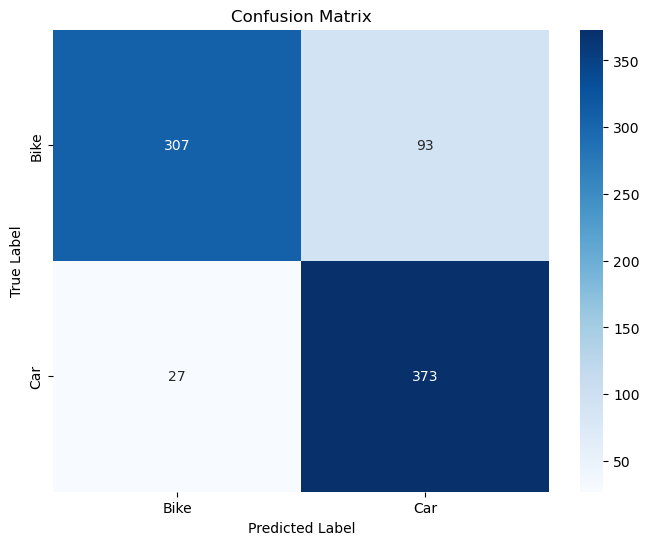

In [42]:
# plotting confusion metrics
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = list(validation_generator.class_indices.keys())

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names)


In [43]:
# Preprocessing the image for prediction 
def process_image(img, target_size=(224, 224)):
    if isinstance(img, str):
        img = image.load_img(img, target_size=target_size)
    else:
        img = img.resize(target_size)
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

In [44]:
car_test_path = 'output/val/Car'
bike_test_path = 'output/val/Bike'

In [45]:
img_car = load_sample_images(car_test_path)
img_bike = load_sample_images(bike_test_path)

In [46]:
validation_generator.class_indices

{'Bike': 0, 'Car': 1}

In [47]:
train_generator.class_indices

{'Bike': 0, 'Car': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


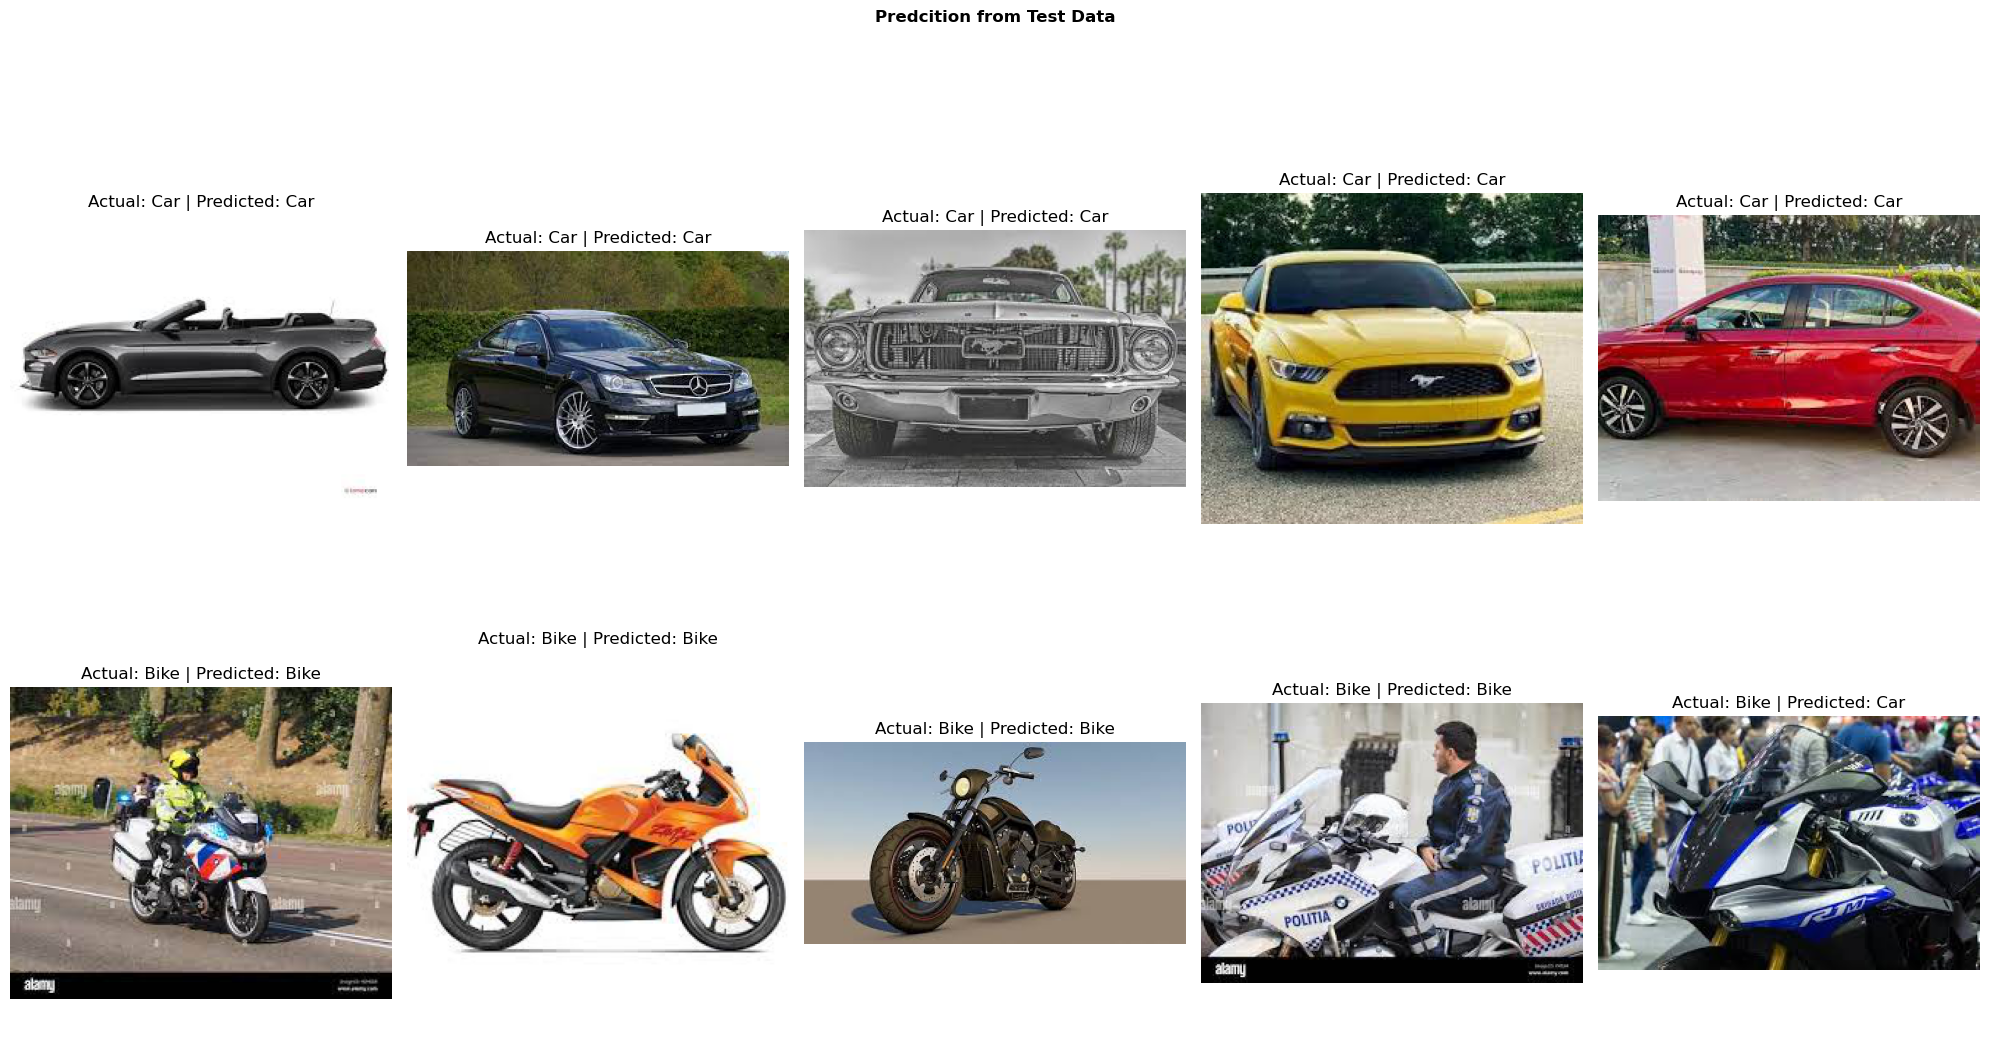

In [48]:
# plotting the prediction with actual and predicted title
test_img = [img_car, img_bike]
fig, axes = plt.subplots(2, len(img_car), figsize=(20,12))
title = ['Actual: Car', 'Actual: Bike']
for row, category in enumerate(test_img):
  for i, img in enumerate(category):
    processed_img = process_image(img)
    pred = model.predict(processed_img)
    pred_title = ' | Predicted: Bike' if pred[0][0] < 0.5 else ' | Predicted: Car'
    axes[row, i].imshow(img)
    axes[row, i].set_title(title[row] + pred_title)
    axes[row, i].axis('off')

plt.suptitle('Predcition from Test Data', fontweight='bold')
plt.tight_layout()
plt.show()